# -*- coding: utf-8 -*-
"""
Created on Sat Feb 19 2022

@author: Ines AGOSSOU, Ines KOUYATE, Nandy MAVUA
@subject: Big Data Tools for Business with Dieudonné TCHUENTE
"""

# **Part 1: Donald Trump Communication Analysis on Twitter 👱‍♂️**

---


***Context:***
*We are big data analysts for a communication agency who wants to analyze
Donald Trump’s communication on Twitter.*

*We have a history of Donald trump tweets: more than 58 000 tweets from 2009 to November 19th, 2020 in the form of a text file - trump_tweets.txt.*
*We are tasked to explore this dataset by using Spark, because our analysis
should also be able to apply on very large data sets, for instance to analyze the
communication on social media of other public figures.*


---

## Installing and importing the required modules and installations 🚧

In [17]:
import pyspark
import numpy as np
import pandas as pd

In [2]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
from datetime import datetime

class Tweet:
    number = 0
    def __init__(self, content):
        self.content = content
        Tweet.number += 1

def format_tweets_file(myfile):
    """Defining a format for the tweets"""
    with open(myfile, 'r', encoding='utf-8') as file:
        tweets_list = []
        tweet = ""
        for line in file:
            if ";" in line:
                tweet += line
                content = tweet
                tweet = Tweet(content)
                tweets_list.append(tweet)
                tweet = ""
            else:
                tweet += line
    return tweets_list


# **SECTION 1: Tweets analysis**

## Import the data and read it into an RDD 📁

In [4]:
sc = pyspark.SparkContext(appName="Spark RDD Trump's tweets")

In [ ]:
# The code below was the first idea but we noticed that some tweets contained sentences contain line breaks... That is why we decided to use another way to open the txt.file.

#rdd_trump_tweets = sc.textFile('trump_tweets.txt')
#rdd_trump_tweets.take(10)

In [5]:
trump_tweets_file = format_tweets_file('trump_tweets.txt')

tweet_list = []
for tweet in trump_tweets_file:
    tweet_list.append(tweet.content)

In [11]:
rdd_tweets = sc.parallelize(tweet_list)
rdd_tweets.take(10)

['\ufeffRepublicans and Democrats have both created our economic problems.;02/08/2011 18:07:48\n',
 'I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish our values, respect our laws, and always put AMERICA FIRST! Thank you for a wonderful evening!! #KAG2020 https://t.co/dNJZfRsl9y;03/03/2020 01:34:50\n',
 'RT @CBS_Herridge: READ: Letter to surveillance court obtained by CBS News questions where there will be further disciplinary action and cho…;17/01/2020 03:22:47\n',
 'The Unsolicited Mail In Ballot Scam is a major threat to our Democracy, &amp  the Democrats know it. Almost all recent elections using this system, even though much smaller &amp   with far fewer Ballots to count, have ended up being a disaster. Large numbers of missing Ballots &amp  Fraud!;12/09/2020 20:10:58\n',
 "RT @MZHemingway: Very friendly telling of events here about Comey's apparent leaking to compliant media. If y

## Quick analysis of tweets over time

In [12]:
from pyspark.sql import SparkSession
spark = SparkSession(sc)

rdd_trump_time_tweets = rdd_tweets.map(lambda line: line.split(';', 1)[1].strip())\
                                  .map(lambda time: time.split(' ')[0].strip())\
                                  .map(lambda x: (x, 1))\
                                  .reduceByKey(lambda a,b : a+b)
rdd_trump_time_tweets.cache()
df_trump_time_tweets = spark.createDataFrame(rdd_trump_time_tweets).toDF("date", "nb_tweets")

In [13]:
df_trump_time_tweets.createOrReplaceTempView("time_series")

In [14]:
df_evolution_time = spark.sql("SELECT * FROM time_series ORDER BY date").toPandas()

In [18]:
# Let's make sure 'date' is actually a date in pandas
df_evolution_time["date"] = pd.to_datetime(df_evolution_time["date"], infer_datetime_format=True, errors='coerce')

In [19]:
df_evolution_time = df_evolution_time.set_index('date')

In [20]:
def times_series_plot(ax, df, time_letter, plot_title):
    """Resampling the data to plot times series for the choosen period."""
    ax.plot(df['nb_tweets'].resample(time_letter).mean())
    ax.set_title(plot_title)

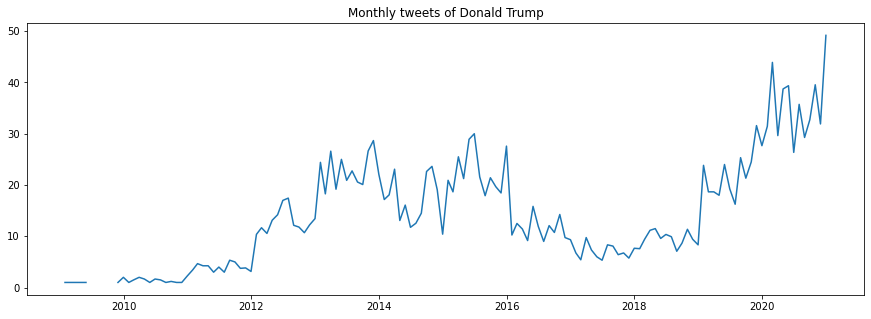

In [21]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))

times_series_plot(ax1, df_evolution_time, 'M', 'Monthly tweets of Donald Trump')

## Clean the data 🧹

#### 2.1. Keep only Donald Trump's tweets (exclude the retweets)

In [22]:
# find the texts of the tweets (remove days, hours)
rdd_trump_tweets = rdd_tweets.map(lambda line: line.split(';', 1)[0]\
                                                         .strip())
rdd_trump_tweets.cache()

# remove retweets
rdd_trump_tweets = rdd_trump_tweets.filter(lambda line: 'RT @' not in line)
rdd_trump_tweets.take(10)

['\ufeffRepublicans and Democrats have both created our economic problems.',
 'I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish our values, respect our laws, and always put AMERICA FIRST! Thank you for a wonderful evening!! #KAG2020 https://t.co/dNJZfRsl9y',
 'The Unsolicited Mail In Ballot Scam is a major threat to our Democracy, &amp  the Democrats know it. Almost all recent elections using this system, even though much smaller &amp   with far fewer Ballots to count, have ended up being a disaster. Large numbers of missing Ballots &amp  Fraud!',
 '“I’m running as a proud Democrat, for the Senate”. Sleepy Joe Biden today. It’s only going to get worse. It is not sustainable for our County - China will own us!!!!',
 'Getting a little exercise this morning! https://t.co/fyAAcbhbgk',
 'https://t.co/4qwCKQOiOw',
 'https://t.co/VlEu8yyovv',
 'https://t.co/z5CRqHO8vg',
 'https://t.co/TQCQiDr

In [23]:
# count the number of tweets

rdd_trump_tweets_count = rdd_trump_tweets.count()
print(f'Donald Trump tweeted {rdd_trump_tweets_count} times.')

Donald Trump tweeted 45781 times.


We observe that Donald Trump's tweets represent a big part of his whole tweets (tweets + retweets). 

#### 2.2. Remove non necessary characters 

In [24]:
import re 
def remove_URL(text):
    """Remove URLs from strings"""
    
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# Remove URLs, digits, special characters, punctuation, 
# capital letters and "only whitespace" words
rdd_trump_tweets_clean = rdd_trump_tweets\
                            .map(lambda x: remove_URL(x))\
                            .map(lambda x: re.sub('\d+', '', x))\
                            .map(lambda x: re.sub(r'[^\w\s]', '', x))\
                            .map(lambda word: word.lower())\
                            .map(lambda x: x.strip())\
                            .filter(lambda x: x != '')
rdd_trump_tweets_clean.cache()

rdd_trump_tweets_clean.take(10)

['republicans and democrats have both created our economic problems',
 'i was thrilled to be back in the great city of charlotte north carolina with thousands of hardworking american patriots who love our country cherish our values respect our laws and always put america first thank you for a wonderful evening kag',
 'the unsolicited mail in ballot scam is a major threat to our democracy amp  the democrats know it almost all recent elections using this system even though much smaller amp   with far fewer ballots to count have ended up being a disaster large numbers of missing ballots amp  fraud',
 'im running as a proud democrat for the senate sleepy joe biden today its only going to get worse it is not sustainable for our county  china will own us',
 'getting a little exercise this morning',
 'thank you elise',
 'as per your request joe',
 'huge win today for the united states and for peace in the world sudan has agreed to a peace and normalization agreement with israel with the unite

#### 2.3. Remove stopwords using the stop-words.txt file

In [25]:
# split the tweets into words 

rdd_trump_tweets_split = rdd_trump_tweets_clean.flatMap(lambda x: x.split(" "))   
rdd_trump_tweets_split.cache()
rdd_trump_tweets_split.take(10)

['republicans',
 'and',
 'democrats',
 'have',
 'both',
 'created',
 'our',
 'economic',
 'problems',
 'i']

In [26]:
# read the stopwords file into an rdd and collect it as a list

list_stopwords = sc.textFile('stop-words.txt').collect()

In [27]:
# add other stopwords 

my_stopwords = sc.parallelize(['trump']).take(1)

In [28]:
# remove the stopwords from the tweets

rdd_tweets_no_stopwords = rdd_trump_tweets_split\
                            .filter(lambda word: word not in list_stopwords)\
                            .filter(lambda word: word not in my_stopwords)

rdd_tweets_no_stopwords.cache()
rdd_tweets_no_stopwords.take(10)

['republicans',
 'democrats',
 'created',
 'economic',
 'problems',
 'thrilled',
 'great',
 'city',
 'charlotte',
 'north']

## 3. Perform a sentiment analysis of Donald Trump's the tweets 💙

#### 3.1. Top positive and top negative words used

In [32]:
list_positive_words =  sc.textFile('positive-words.txt').collect()
list_negative_words =  sc.textFile('negative-words.txt').collect()

In [33]:
def rdd_keep_words(rdd_clean, list_polarity, polarity):
    """Keep the words according to their polarity and order them 
in descending order"""

    rdd_polarity = rdd_clean\
        .filter(lambda x: x in list_polarity)\
        .map(lambda x: (x, 1))\
        .reduceByKey(lambda a,b: a+b)\
        .sortBy(lambda tuple: tuple[1], 
                ascending=False)
    
    print(f'Top 10 {polarity} words used by Donald Trump:')
    for key, value in rdd_polarity.take(10):
        print(f'{key} = {value}')
        
    return rdd_polarity

In [34]:
rdd_trump_positive = rdd_keep_words(rdd_tweets_no_stopwords, list_positive_words, 'positive')
rdd_trump_positive.cache()

Top 10 positive words used by Donald Trump:
great = 7095
thank = 3264
like = 1819
good = 1714
best = 1151
love = 1079
win = 1028
work = 894
better = 794
right = 788


PythonRDD[55] at RDD at PythonRDD.scala:53

In [35]:
rdd_trump_negative = rdd_keep_words(rdd_tweets_no_stopwords, list_negative_words, 'negative')
rdd_trump_negative.cache()

Top 10 negative words used by Donald Trump:
fake = 1147
bad = 969
hard = 698
crime = 511
crooked = 438
wrong = 411
illegal = 369
terrible = 365
lost = 338
radical = 323


PythonRDD[67] at RDD at PythonRDD.scala:53

#### 3.2. Compute the global sentiment score

In [36]:
sentiment_score = rdd_trump_positive.values().sum() - rdd_trump_negative.values().sum()
print("The sentiment score is :", sentiment_score)

The sentiment score is : 17336


**Observation**: In terms of quantity, we can observe that Donald Trump tweets more positively than negatively. 
Indeed, the positive words are way more numerous than the negative ones (top 10). This is confirmed by the global sentiment score (i.e. 17,336)

## 4. Visualize polarized opinions from Trump's tweets

#### 4.1. Wordclouds of positive and negative words used in his tweets

In [38]:
# create dictionnaries to plot wordclouds

dic_pos = rdd_trump_positive.collectAsMap()
dic_neg = rdd_trump_negative.collectAsMap()

In [39]:
# define functions to select a hue of colors for the wordclouds 

def red_color_func(**kwargs):
    """Define a hue of red colors"""
    return "hsl(0, 100%%, %d%%)" % np.random.randint(30, 50)

def green_color_func(**kwargs):
    """Define a hue of green colors"""
    return "hsl(100, 100%%, %d%%)" % np.random.randint(20, 40)

def plot_wordclouds(x, color_func, polarity_dic, polarity_title, max_words):
    """Plot colored wordclouds"""
    
    word_cloud = WordCloud(width=800,
                           height=400, 
                           max_words=max_words, 
                           min_font_size=8)\
                    .generate_from_frequencies(polarity_dic)
    plt.subplot(x)
    plt.imshow(word_cloud.recolor(color_func=color_func, 
                                  random_state=3),
               interpolation="bilinear")
    plt.title(f"Most frequent {polarity_title} words used by Donald Trump")
    plt.axis("off")

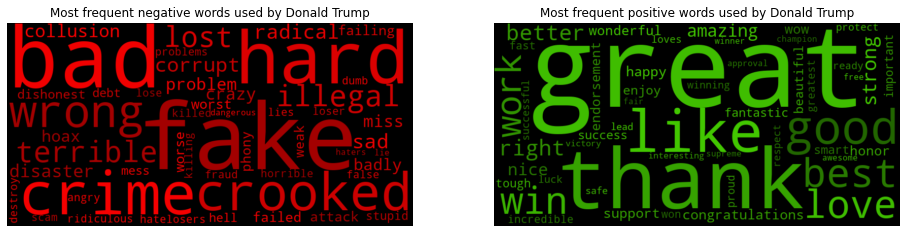

In [40]:
# plot the positive and negatie wordclouds

plt.fig = plt.figure(figsize=(16,12))
plot_wordclouds(121, red_color_func, dic_neg, 'negative', 50)
plot_wordclouds(122, green_color_func, dic_pos, 'positive', 50)

#### 4.2. Barplot of positive and negative words used in his tweets

In [41]:
from matplotlib import pyplot as plt
import seaborn as sb

import pandas as pd

def plot_opinion(x, pos_list, neg_list, plot_title):
    """Plot a bar chart presenting top positives and top negatives words.
    The parameters are list of tuples containing counts from positives and negatives words
"""
    
    list_1 = [(t[0], t[1], 'positive') for t in pos_list]
    list_2 = [(t[0], t[1], 'negative') for t in neg_list]
    
    list_1.extend(list_2)
    
    pd_df = pd.DataFrame({
     'Opinion': [ t[0] for t in list_1 ],
     'Count': [ t[1] for t in list_1 ],
     'polarity': [ t[2] for t in list_1 ]
    }).sort_values('Count', ascending=False)
    
    pd_df['color'] = pd_df.polarity.apply(lambda polarity: 'green' 
                                          if polarity=='positive' else 'red')
    
    plt.figure( figsize = (10, 5) )
    plt.subplot(x)
    plt.title(plot_title)
    
    chart=sb.barplot(data=pd_df, 
                     x='Opinion', 
                     y='Count', 
                     hue='polarity', 
                     palette=["green", "red"], 
                     order=pd_df['Opinion'])
    
    chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=80, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large',
    )
    
    for tick, color in zip(chart.get_xticklabels(), pd_df['color']): 
        tick.set_color(color)
    
    plt.show()

In [42]:
# create list 
list_pos = rdd_trump_positive.take(20)
list_neg = rdd_trump_negative.take(20)

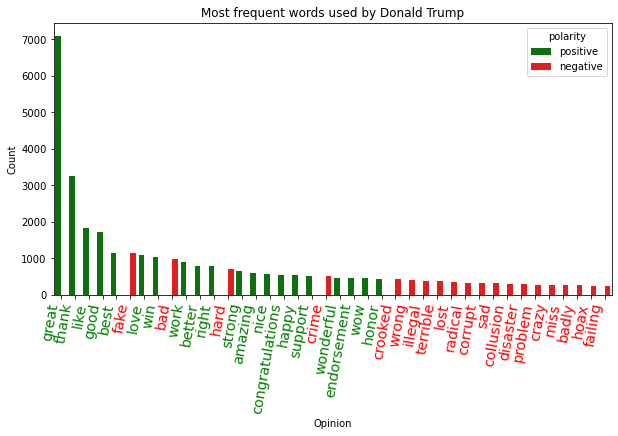

In [43]:
plot_opinion(111, list_pos, list_neg, "Most frequent words used by Donald Trump")

#### 4.3. Wordcloud of contextual words

In [44]:
list_stopwords_context = sc.parallelize(['', 'trump', 'realdonaldtrump', 'donald']).take(4)
rdd_trump_context = rdd_tweets_no_stopwords\
                            .filter(lambda x: 
                                    x not in list_positive_words)\
                            .filter(lambda x: 
                                    x not in list_negative_words)\
                            .filter(lambda x: 
                                    x not in list_stopwords_context)\
                            .map(lambda x: (x, 1))\
                            .reduceByKey(lambda a,b: a+b)\
                            .sortBy(lambda tuple: tuple[1], ascending=False)

#rdd_trump_context.take(5)

In [45]:
dic_context = rdd_trump_context.collectAsMap() 

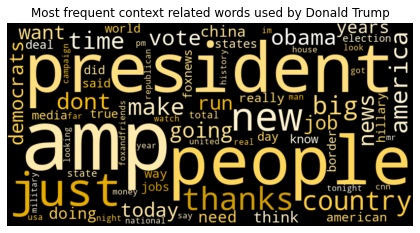

In [46]:
def orange_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(45,100%%,%d%%)" % np.random.randint(40,100)

plt.fig = plt.figure(figsize=(16,12))
plot_wordclouds(121, orange_color_func, dic_context, 'context related', 70)

**Observation:** Having a look at the contextual words can be useful to explore what are the main themes Donald Trump express himself about.
The word "thanks" that can also be considered positive, is quite often used by the former president of the US.

# **SECTION 2: COVID analysis**
### *Analysis of Donald Trump's tweets related to the Covid situation 🦠*

In [47]:
# filter on the tweets related to covid only

rdd_covid_related = rdd_trump_tweets_clean.filter(lambda line: ('covid' or 'corona') in line)
rdd_covid_related.cache()
rdd_covid_related.take(10)

['joe bidens response to the hn swine flu far less lethal than covid  was one of the weakest and worst in the history of fighting epidemics and pandemics it was pathetic those involved have said joe didnt have a clue',
 'governor cuomo has shown tremendously poor leadership skills in running ny bad time for him to be writing and promoting a book especially since he has done such a poor job with covid and crime so many unnecessary deaths the city amp  state have sunk to historic lows',
 'the great bobby bowden one of the best coaches ever in college football on his full recovery from covid america is the greatest country this side of heaven ive had a chance to get a lot of wins in my life but i really wanted to win this one because i wanted',
 'we have made tremendous progress with the china virus but the fake news refuses to talk about it this close to the election covid covid covid is being used by them in total coordination in order to change our great early election numbersshould be

### Contextual words (covid)

In [48]:
list_covid_stopwords = sc.parallelize(['', 'trump']).take(2)

In [49]:
# split the tweets into words 

rdd_covid_related_split = rdd_covid_related\
                            .flatMap(lambda x: x.split(" "))\
                            .filter(lambda x: 
                                    x not in list_stopwords)\
                            .filter(lambda x: 
                                    x not in list_covid_stopwords)
rdd_covid_related_split.cache()

rdd_contextual_words = rdd_covid_related_split\
                            .filter(lambda x: x != '')\
                            .filter(lambda x: 
                                    x not in list_positive_words)\
                            .filter(lambda x: 
                                    x not in list_negative_words)
rdd_contextual_words.cache()

# rdd_contextual_words.take(10)

PythonRDD[94] at RDD at PythonRDD.scala:53

In [50]:
rdd_contextual_words_count = rdd_contextual_words\
                            .map(lambda x: (x, 1))\
                            .reduceByKey(lambda a,b: a+b)\
                            .sortBy(lambda tuple: tuple[1], ascending=False)

rdd_contextual_words_count.take(10)

[('covid', 56),
 ('news', 10),
 ('media', 8),
 ('election', 7),
 ('people', 6),
 ('amp', 5),
 ('doing', 5),
 ('job', 5),
 ('big', 5),
 ('really', 4)]

### Positive and negative words (covid)

In [51]:
rdd_covid_positive = rdd_keep_words(rdd_covid_related_split, list_positive_words, 'covid related positive')
rdd_covid_negative = rdd_keep_words(rdd_covid_related_split, list_negative_words, 'covid related negative')

Top 10 covid related positive words used by Donald Trump:
great = 11
good = 6
win = 3
relief = 3
like = 2
better = 2
greatest = 2
positive = 2
support = 2
recovery = 2
Top 10 covid related negative words used by Donald Trump:
fake = 9
virus = 4
death = 3
poor = 3
slow = 2
terrible = 2
crime = 2
refuses = 2
bad = 2
hard = 2


### Visualizations

In [52]:
dic_context_covid = rdd_contextual_words_count.collectAsMap() 
dic_pos_covid = rdd_covid_positive.collectAsMap()
dic_neg_covid = rdd_covid_negative.collectAsMap()

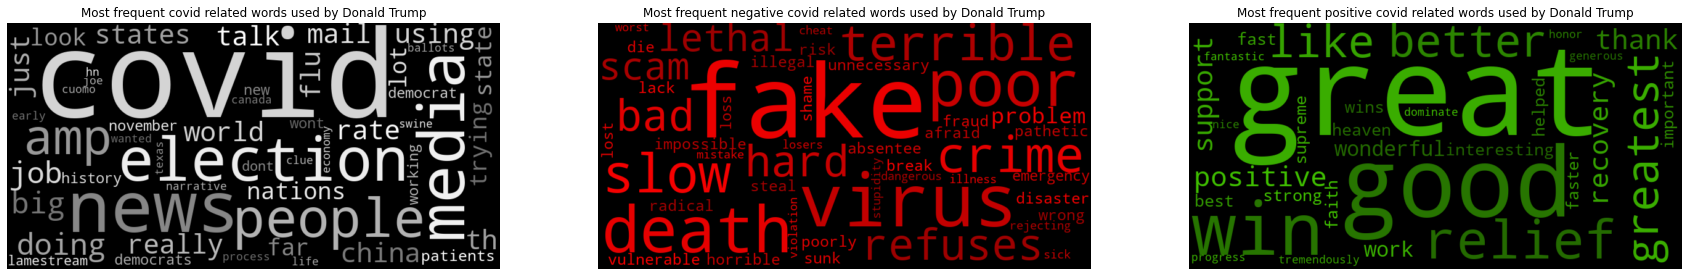

In [53]:
def grey_color_func(**kwargs):
    """Define a hue of grey colors"""
    return "hsl(0, 0%%, %d%%)" % np.random.randint(40, 100)


plt.fig = plt.figure(figsize=(30,20))
plot_wordclouds(131, grey_color_func, dic_context_covid, 'covid related', 50)
plot_wordclouds(132, red_color_func, dic_neg_covid, 'negative covid related', 50)
plot_wordclouds(133, green_color_func, dic_pos_covid, 'positive covid related', 50)

**Observation:** When it goes to the COVID situation, we realise that the positive words are not as used as in the normal situation.
In fact, the positive and negative words seem to be quite equal when related to COVID. 
We can interpret that by saying that Donald Trump was not that much optimistic about the sanitary situation.

In [54]:
# Barplot

list_contextual_words = rdd_contextual_words_count.filter(lambda x: 
                                    x[0] not in ['covid']).take(20)

def plot_contextual_words(list_contextual_words, plot_title):
    """The utility function plot_contextual_words plots a bar chart presenting top contextual words
    the parameter are list of tuples containing counts from contextual words"""
    
    pd_df = pd.DataFrame({
        'Word':  [ t[0] for t in list_contextual_words ],
        'Count': [ t[1] for t in list_contextual_words ]
    }).sort_values('Count', ascending=False)
    
    plt.figure( figsize = (10, 5) )
    plt.title(plot_title)
    
    chart=sb.barplot(data=pd_df, x='Word', y='Count', order=pd_df['Word'], color='grey')
    
    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=80, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large',
        )
    
    plt.show()

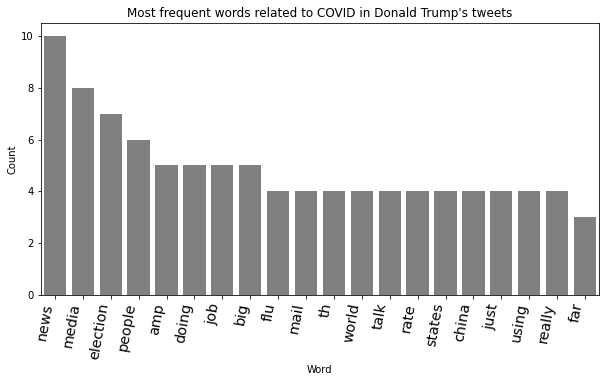

In [55]:
plot_contextual_words(list_contextual_words, "Most frequent words related to COVID in Donald Trump's tweets")

# **SECTION 3: Retweet analysis**

# **Retweet analysis**

**Documentation** : 
* Install NLP: https://nlp.johnsnowlabs.com/docs/en/install#python
* Upgrade Java to java 8: https://docs.datastax.com/en/jdk-install/doc/jdk-install/installOracleJdkRHEL.html
* NLP Spark: https://cedric.cnam.fr/vertigo/Cours/RCP216/tpNlp.html

In [59]:
# find the texts of the retweets (remove days, hours), replace the new space created because of the previous line of code
rdd_trump_retweets = rdd_tweets.filter(lambda line: 'RT @' in line)\
                                     .map(lambda line: line.split(';', 1)[0]\
                                         .strip())\

rdd_trump_retweets.take(10)

['RT @CBS_Herridge: READ: Letter to surveillance court obtained by CBS News questions where there will be further disciplinary action and cho…',
 "RT @MZHemingway: Very friendly telling of events here about Comey's apparent leaking to compliant media. If you read those articles and tho…",
 'RT @WhiteHouse: President @realDonaldTrump announced historic steps to protect the Constitutional right to pray in public schools! https://…',
 'RT @EricTrump: https://t.co/NcrNdOSfIV',
 '"RT @GOPChairwoman: The economic boom continues!\n\n273K jobs added in February \n\n7M+ jobs added since @realDonaldTrump was elected\n\nUnemploym…"',
 "RT @TomFitton: Vindman's behavior is a scandal. He should be removed from the @RealDonaldTrump White House ASAP to protect our foreign poli…",
 "RT @marklevinshow: President Trump was outstanding.\xa0 I couldn't be prouder.\xa0 Biden was making faces and was very dishonest about some of hi…",
 'RT @RealRLimbaugh: Winning, winning, winning! @realDonaldTrump',
 'RT @

In [60]:
# count the number of retweets

rdd_trump_retweets_count = rdd_trump_retweets.count()
print(f'Donald Trump retweeted {rdd_trump_retweets_count} tweets.')

Donald Trump retweeted 9733 tweets.


In [61]:
# Remove the name of the user, URLs, digits, special characters, punctuation, 
# capital letters and "only whitespace" words
rdd_trump_retweets_clean = rdd_trump_retweets\
                            .map(lambda line: line.split(' @', 1)[1].strip())\
                            .map(lambda rtweet: rtweet.split(':', 1)[1].strip())\
                            .map(lambda x: re.sub('\xa0', '', x))\
                            .map(lambda x: re.sub('\n', '', x))\
                            .map(lambda x: remove_URL(x))\
                            .map(lambda x: re.sub('\d+', '', x))\
                            .map(lambda x: re.sub(r'[^\w\s]', '', x))\
                            .map(lambda word: word.lower())\
                            .map(lambda x: x.strip())\
                            .filter(lambda x: x != '')
rdd_trump_retweets_clean.take(10)

['read letter to surveillance court obtained by cbs news questions where there will be further disciplinary action and cho',
 'very friendly telling of events here about comeys apparent leaking to compliant media if you read those articles and tho',
 'president realdonaldtrump announced historic steps to protect the constitutional right to pray in public schools',
 'the economic boom continuesk jobs added in february m jobs added since realdonaldtrump was electedunemploym',
 'vindmans behavior is a scandal he should be removed from the realdonaldtrump white house asap to protect our foreign poli',
 'president trump was outstanding i couldnt be prouder biden was making faces and was very dishonest about some of hi',
 'winning winning winning realdonaldtrump',
 'i guarantee it was the st time millions of americans learned the kids in cages was obama not trump because the medi',
 'trump won this debate handily biden wasnt a force at all trump was substantive onpoint welltempered definitel

In [62]:
# split the tweets into words 

rdd_trump_retweets_split = rdd_trump_retweets_clean\
                            .flatMap(lambda x: x.split(" "))   
rdd_trump_retweets_split.take(10)

['read',
 'letter',
 'to',
 'surveillance',
 'court',
 'obtained',
 'by',
 'cbs',
 'news',
 'questions']

In [63]:
# remove the stopwords from the tweets

rdd_retweets_no_stopwords = rdd_trump_retweets_split\
                            .filter(lambda word: word not in list_stopwords)
rdd_retweets_no_stopwords.cache()
rdd_retweets_no_stopwords.take(10)

['read',
 'letter',
 'surveillance',
 'court',
 'obtained',
 'cbs',
 'news',
 'questions',
 'disciplinary',
 'action']

In [65]:
rdd_rt_trump_positive = rdd_keep_words(rdd_retweets_no_stopwords, list_positive_words, 'positive')

In [41]:
rdd_rt_trump_negative = rdd_keep_words(rdd_retweets_no_stopwords, list_negative_words, 'negative')

Top 10 negative words used by Donald Trump:
breaking = 156
fake = 89
collusion = 71
radical = 62
hard = 55
sham = 54
impeach = 52
abuse = 50
critical = 48
crisis = 48


In [42]:
# create list 

list_rt_pos = rdd_rt_trump_positive.take(20)
list_rt_neg = rdd_rt_trump_negative.take(20)

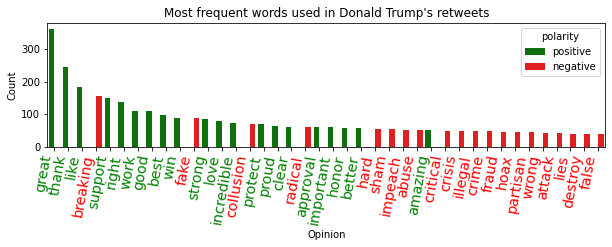

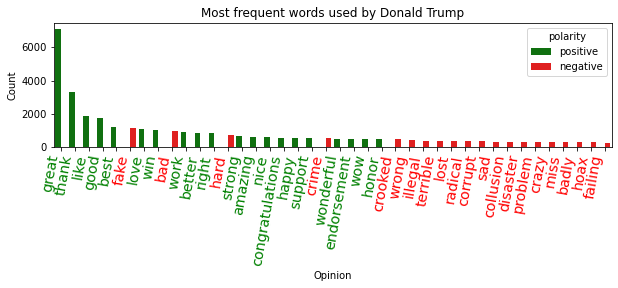

In [52]:
plot_opinion(211, list_rt_pos, list_rt_neg, "Most frequent words used in Donald Trump's retweets")
plot_opinion(212, list_pos, list_neg, "Most frequent words used by Donald Trump")

The difference between Donald Trump's tweets and retweets is not that flagrant. 
The word "breaking" appears a lot in his retweets, that may refer to the expression "Breaking news", often used by reporters.

# **Hashtag analysis** 

In [54]:
rdd_trump_HTtweets = rdd_tweets.filter(lambda line: '#' in line)
rdd_trump_HTtweets.take(10)

['Republicans and Democrats have both created our economic problems.;02/08/2011 18:07:48',
 'I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish our values, respect our laws, and always put AMERICA FIRST! Thank you for a wonderful evening!! #KAG2020 https://t.co/dNJZfRsl9y;03/03/2020 01:34:50',
 'RT @CBS_Herridge: READ: Letter to surveillance court obtained by CBS News questions where there will be further disciplinary action and cho…;17/01/2020 03:22:47',
 'The Unsolicited Mail In Ballot Scam is a major threat to our Democracy, &amp  the Democrats know it. Almost all recent elections using this system, even though much smaller &amp   with far fewer Ballots to count, have ended up being a disaster. Large numbers of missing Ballots &amp  Fraud!;12/09/2020 20:10:58',
 "RT @MZHemingway: Very friendly telling of events here about Comey's apparent leaking to compliant media. If you read those 

In [83]:
# count the number of retweets

rdd_trump_HTweets_count = rdd_trump_HTtweets.count()
print(f'Donald Trump has {rdd_trump_HTweets_count} tweets that include hashtags.')

Donald Trump has 7416 tweets that include hashtags.


In [65]:
rdd_trump_HT_splited = rdd_trump_HTtweets.flatMap(lambda element : element.split())\
                    .filter(lambda element: '#' in element)
rdd_trump_HT_splited.take(10)

['#KAG2020',
 '#MAGA',
 '#VOTE',
 '#MAGA🇺🇸🦅rally',
 '#VOTE',
 '#2A,',
 '#VOTE',
 '#MAGA',
 '"#VoteEarlyDay',
 '#MAGA🇺🇸']

In [77]:
# Remove URLs, special characters, punctuation, 
# capital letters and "only whitespace" words
rdd_trump_HTtweets_cleaned = rdd_trump_HT_splited\
                            .map(lambda x: re.sub(r'[^\w\s]', ' ', x))\
                            .map(lambda word: word.lower())\
                            .map(lambda x: x.strip())\
                            .filter(lambda x: x != '')\
                            .map(lambda word: word.split()[0])\
                            .map(lambda word : "#"+word)
rdd_trump_HTtweets_cleaned.take(10)

['#kag2020',
 '#maga',
 '#vote',
 '#maga',
 '#vote',
 '#2a',
 '#vote',
 '#maga',
 '#voteearlyday',
 '#maga']

In [78]:
rdd_trump_mostHT = rdd_trump_HTtweets_cleaned\
                            .map(lambda x: (x, 1))\
                            .reduceByKey(lambda a,b: a+b)\
                            .sortBy(lambda tuple: tuple[1], ascending=False)
rdd_trump_mostHT.take(10)

[('#trump2016', 794),
 ('#maga', 521),
 ('#makeamericagreatagain', 461),
 ('#celebapprentice', 297),
 ('#celebrityapprentice', 150),
 ('#1', 143),
 ('#trump', 126),
 ('#timetogettough', 97),
 ('#americafirst', 96),
 ('#trumpvlog', 83)]

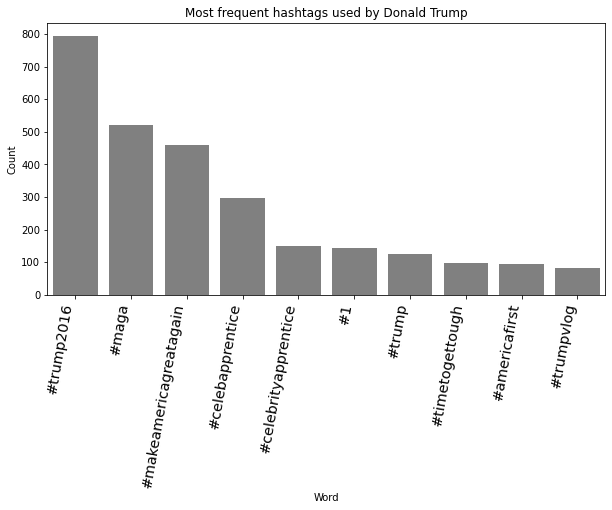

In [136]:
plot_contextual_words(rdd_trump_mostHT.take(10), "Most frequent hashtags used by Donald Trump")

Most hashtags used by Donald Trump are related to his presidential campaign (slogans, campaign name, ...). 
They are quite contextual.

# **Mentions analysis (@)** 

In [123]:
rdd_trump_mentions_tweets = rdd_tweets.filter(lambda line: '@' in line)
rdd_trump_mentions_tweets.take(10)

['RT @CBS_Herridge: READ: Letter to surveillance court obtained by CBS News questions where there will be further disciplinary action and cho…;17/01/2020 03:22:47',
 "RT @MZHemingway: Very friendly telling of events here about Comey's apparent leaking to compliant media. If you read those articles and tho…;17/01/2020 13:13:59",
 'RT @WhiteHouse: President @realDonaldTrump announced historic steps to protect the Constitutional right to pray in public schools! https://…;17/01/2020 00:11:56',
 'RT @EricTrump: https://t.co/NcrNdOSfIV;23/10/2020 04:30:19',
 '"RT @GOPChairwoman: The economic boom continues!',
 '7M+ jobs added since @realDonaldTrump was elected',
 "RT @TomFitton: Vindman's behavior is a scandal. He should be removed from the @RealDonaldTrump White House ASAP to protect our foreign poli…;07/02/2020 17:35:20",
 "RT @marklevinshow: President Trump was outstanding.\xa0 I couldn't be prouder.\xa0 Biden was making faces and was very dishonest about some of hi…;23/10/2020 03:58:38",

In [124]:
# count the number of mentions

rdd_trump_mentions_tweets_count = rdd_trump_mentions_tweets.count()
print(f'Donald Trump has {rdd_trump_mentions_tweets_count} tweets that mention people.')

Donald Trump has 32531 tweets that mention people.


In [125]:
rdd_trump_mentions_tweets_splited = rdd_trump_mentions_tweets.flatMap(lambda element : element.split())\
                    .filter(lambda element: '@' in element)
rdd_trump_mentions_tweets_splited.take(10)

['@CBS_Herridge:',
 '@MZHemingway:',
 '@WhiteHouse:',
 '@realDonaldTrump',
 '@EricTrump:',
 '@GOPChairwoman:',
 '@realDonaldTrump',
 '@TomFitton:',
 '@RealDonaldTrump',
 '@marklevinshow:']

In [131]:
# Remove URLs, special characters, punctuation, 
# capital letters and "only whitespace" words
rdd_trump_mentions_tweets_cleaned = rdd_trump_mentions_tweets_splited\
                            .map(lambda x: re.sub(r'[^\w\s]', ' ', x))\
                            .map(lambda word: word.lower())\
                            .map(lambda x: x.strip())\
                            .filter(lambda x: x != '')\
                            .map(lambda word: word.split()[0])\
                            .map(lambda word : "@"+word)
rdd_trump_mentions_tweets_cleaned.take(10)

['@cbs_herridge',
 '@mzhemingway',
 '@whitehouse',
 '@realdonaldtrump',
 '@erictrump',
 '@gopchairwoman',
 '@realdonaldtrump',
 '@tomfitton',
 '@realdonaldtrump',
 '@marklevinshow']

In [132]:
rdd_trump_most_mentions = rdd_trump_mentions_tweets_cleaned\
                            .map(lambda x: (x, 1))\
                            .reduceByKey(lambda a,b: a+b)\
                            .sortBy(lambda tuple: tuple[1], ascending=False)
rdd_trump_most_mentions.take(10)

[('@realdonaldtrump', 11049),
 ('@foxnews', 940),
 ('@whitehouse', 838),
 ('@barackobama', 710),
 ('@foxandfriends', 704),
 ('@cnn', 403),
 ('@apprenticenbc', 402),
 ('@ivankatrump', 330),
 ('@seanhannity', 315),
 ('@mittromney', 314)]

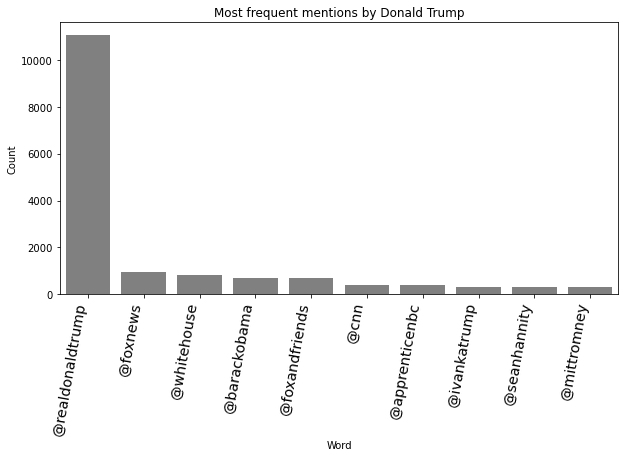

In [137]:
plot_contextual_words(rdd_trump_most_mentions.take(10), "Most frequent mentions by Donald Trump")

Most people that Donald Trump mentions in his tweets are related to the presidence (White House, Barack Obama,...), as well as as news television channels (Fox News, CNN,...)